<h1 align="center"><strong><font size="6"> The Soccer-Factor-Model <br> Identifying a Soccer-Player's Skill/Ability via Bayesian Logistic Regression </h1></strong></font>

<br>

(Actually, it's football, the *jogo bonito* that you play with your feet. But oddly, Americans call it *soccer*.)


Welcome to the notebook hosting the **Soccer-Factor-Model** (SFM). Before jumping into a short introduction into what the SFM actually is, I would like to make a few remarks upfront:

1. The SFM is not confined to soccer only, but can easliy be adpated to all kinds of other sports: football, baseball, basketball, Formula 1, etc. The only requirement: **data on individual players and/or teams**.

2. The model itself is implemented with the enormous help of **[#PyMC](https://www.pymc.io/welcome.html)**.

3. Given that **[#PyMC](https://www.pymc.io/welcome.html)** thankfully does all the heavy work, the actual **star** of the analysis is not the model construction and estimation, but rather the data/feature engineering part.

<br>

<br>
<br>

## <font size="6.5"> &emsp; &emsp; **0. &emsp; Pre-Game Ramblings**</font>

<br>

## 0.1 &emsp; What's the Soccer-Factor-Model all about?

<br>

### **The Inspiration**
The Soccer-Factor-Model (SFM) is inspired by the academic literature on asset-pricing along the following lines:

> 1. Factor Models à la [Fama & French](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1992.tb04398.x) use "factors" to explain the cross-section of stock returns. <br>
 --> **here**: we use "Team-Factors" to explain away the role of the team's strength in making a given player $i$ score a goal.

> 2. There is some literature on the skill of investment fund managers that works in a similar way: "explain away" that proportation of a Fund's returns that is related to economic fundamentals (e.g. [Coggin, Fabozzi, Rahman (1993)](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1993.tb04029.x); [Fama & French (2010)](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.2010.01598.x); [Berg & van Binsbergen (2015)](https://www.sciencedirect.com/science/article/pii/S0304405X15000628)):
\begin{align}
  r_{p,t} = \alpha_p + \sum^N_{n=1} \beta_n \, f_{n,t} + \varepsilon_{p,t}
\end{align} <br>
 where $r_{p,t}$ is portfolio $p$'s return in excess of the risk-free rate (e.g. short-term U.S. government bonds). $f_{n,t}$ measures the return that one could generate by following the strategy prescribed by **factor $n$**, and $\varepsilon_{p,t}$ is a random error that is usually assumed to be mean zero. <br> The parameter of interest here is $\mathbf{\alpha_p}$. It is that part of a portfolio's conditional mean, that is not to be explained by the factors $f_{1,t},...,f_{N,t}$, and is a measure of the portfolio manager's **skill/ability**. Said differently: it quantifies the manager's ability to generate returns **beyond** the return you would have received by just following the investment strategy dictated by the factors.


<br>


### **From Asset-Pricing to Soccer**

In our case, the "dependent variable"/"label"/"outcome variable" ($y_{i,s,m}$) will be a binary indicator, telling us whether player $i$ has scored a goal (or not) in season $s$ in match $m$:

\begin{align}
        y_{i,s,m} = \left\{
        \begin{array}{cl}
        0 & \textbf{not} \text{ scored} \\
        1 & \text{scored}
        \end{array}
        \right.
\end{align}




> *Sidenote*: This binary classification exercise is just a way to keep things simple. One may also want to predict the *number* of goals in a given match, which would make it for a multiclass extension.

<br>

The SFM is then set-up as follows:

<br>

\begin{align}
     p_{i,s,m} \equiv   P\left(y_{i,s,m} = 1 | \mathbf{x}_{i,s,m-1}, \alpha_i, \beta \right) = \sigma \left(\alpha_{i} + \mathbf{x}_{i,s,m-1} \, \mathbf{\beta} \right) \qquad \left( M.1 \right)
\end{align}

<br>

where

> - $p_{i,s,m}$: &ensp;&ensp;&emsp; The probability of player $i$ scoring a goal in season $s$ in match $m$ *conditional* on $\mathbf{x}_{i,s,m-1}$, $\alpha_i$, and $\beta \;$ ;

> - $\mathbf{x}_{i,s,m-1}$: &emsp; A $\; 1 \times N$ vector of *factors* that are intended to resemble the imbalance between player $i$'s team and the <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; opponent-team. The subscript $m-1$ signals that these *factors* only contain information about the teams' <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; differences that prevails **before** the referee blows the whistle to start off match $m$ ! <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; Again, to be clear, these *factors* are intended to explain that fraction of $p_{i,s,m}$ that is due to the difference in the <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; strength  of player $i$'s team and the opponent-team;

> - $\beta$: &ensp;&ensp;&ensp;&ensp;&ensp;&emsp; The sensitivity of $p_{i,s,m}$ to the factors $\mathbf{x}_{i,s,m} \;$;

> - $\alpha_i$: &ensp;&ensp;&ensp;&ensp;&ensp; Our main parameter of interest as it captures that fraction of $p_{i,s,m}$ that is attributed toplayer $i$'s skill/ability only! <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; (Yes, later on, this parameter will carry a subscript $s$, $\alpha_{i,s} \;$, allowing a player's skill/ability to vary across seasons);

> - $\sigma \left(\cdot\right)$: &ensp;&ensp;&emsp; The $\mathtt{sigmoid}$ function, which transforms the predictions of the linear model $\alpha_i + \mathbf{X}_i \, \mathbf{\beta}$ into a number that <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; ranges between zero and one, such that $p_{i,s,m} \in \left[0;1\right]$.


<br>

Just for notational convenience, we will re-write Equation ($M.1$) to get rid off the subscripts $s$ and $m$:

<br>

\begin{align}
     p_{i} \equiv   P\left(Y_{i} = 1 | \mathbf{X}_{i}, \alpha_i, \beta \right) = \sigma \left(\alpha_{i} + \mathbf{X}_{i} \, \mathbf{\beta} \right) \qquad \left( 1 \right )
\end{align}

<br>

where now

> - $Y_{i}$: &ensp;&ensp;&ensp;&ensp;&ensp; A $\; \left(\sum^{S_i}_{s=1} M_{i,s}\right) \times 1$ vector of zeros and ones,
> - $\mathbf{X}_i$: &ensp;&ensp;&ensp;&ensp;&emsp; A $\; \left(\sum^{S_i}_{s=1} M_{i,s}\right) \times N$ matrix of *factors*
> > where
> > - $S_i$:  &ensp;&ensp;&ensp; The total number of seasons player $i$ has played,
> > - $M_{i,s}$: &ensp; The total number of matches played by player $i$ in season $s$.
> - $p_{i}$: &ensp;&ensp;&ensp;&ensp;&ensp; With a slight abuse of notation, a $\; \left(\sum^{S_i}_{s=1} M_{i,s}\right) \times 1$ vector of probabilities, with $p_{i} \in \left[0;1\right]$.

<br>

<font color='darkred'>**IMPORTANT**</font>: &emsp; The explanatory variables (*factors*, $\mathbf{X}_i$) describe the *state* that had persisted **before** a given match $m$ was played.  <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; E.g., when we observe $y_{i,s,m}$, the *factors* will only capture information that was available to us **prior to** match $m$! <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Therefore, we will have the following mapping: $y_{i,s,m} \rightarrow \mathbf{x}_{i,s,m-1}$.

<br>

<br>

## 0.2 &emsp; Factors: The Heart of the SFM

<br>



Factors are intended to help us understand which part of $p_i$ is due to the strength of the **team** ( $\mathbf{X}_i \, \mathbf{\beta}$ ) that player $i$ is playing for, and which proportion of $p_i$ is due to player $i$'s **own** ($\alpha_i$) skill/ability. In that sense, $\alpha_i$ is our main parameter of interest as it gives us a measure of the **skill/ability** of player $i$ to score a goal.

<font color='darkred'>**NOTE**</font>: &emsp; Hard-core finance academics might be outraged with me making a comparison between the SFM-factors ($\mathbf{x}_{i,s,m-1}$) that I introduce below, and the **true** asset-pricing factors ($f_t$) mentioned above.
One reason is that the SFM-factors carry an additional subscript $i$, which indicates that these factors vary across teams or even across players. In contrast, the traditional asset-pricing factors are only varying across time, but are *invariant* across entities.

<br>

<br>

## 0.3 &emsp; Factor Engineering

<br>

The number of *factors* we can build and their informative value, depends obviously on the data that is available to us. For the following exercise, I depend on publicly available data free of charge. That is already a limitation for producing a meaningful model.

However, I guess I found a decent dataset, which I pulled from [#Kaggle](https://www.kaggle.com/datasets/marclamyhshshs/premier-league-games?select=clean_players_info.csv).
All credits for that dataset go to [Marc Lamyhshshs](https://www.kaggle.com/marclamyhshshs).
It comprises all Premier League matches since 1992, which allows us to look at some very, very, very interesting players!

The amount of data is surely impressive! This allows us to create some interesting *factors*.

<br>

To showcase how SFM works, I chose to construct the following ones:


- `goalsscored_diff`: &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; The current difference of *goals scored* by player $i$'s team and the opponent-team
- `goalsscored_rank_team`: &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; The current ranking of player $i$'s team in *goals scored*
- `goalsscored_rank_team_wo_player`: &emsp; The current ranking of player $i$'s team in *goals scored*, not accounting for <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&emsp;&emsp; the number of goals scored by player $i$
- `goalsconceded_rank_opp`: &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&emsp; The current ranking of the opponent-team in *goals conceded*
- `points_diff`: &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&emsp;&emsp; The difference in points of the player's team and the opponent
- `goal_balance_team`: &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; The difference between *goals scored* and *goals conceded* of the team which <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&emsp;&emsp; our player of interest is playing for
- `goal_balance_opp`: &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; The difference between *goals scored* and *goals conceded* of the opponent-team which <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&emsp;&emsp; our player of interest is playing against in match $m$
- `goal_balance_diff`: &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; The difference between `goal_balance_team` and `goal_balance_opp`


Throughout the notebook, I attached some questions about whether a given factor is actually related to team-effort or actually an indication of a player's strength ... if the latter were true, we should exclude that particular factor as our model would be mis-specified! Or we would just hope that the posterior of the corresponding loading is centered around zero with only little variance...


<br>

<font color='darkred'>**Lastly:**</font> : This list of factors is by no means comprehensive and much more creative minds might already have thought of many more fancy factors to built from the underlying data.
Feel free to build your own factors! Data on `shots_home` and `shots_away` sound to have potential to form other interesting explanatory variables that I haven't included yet!


<br>

<br>

## 0.4 &emsp; Outline of the Notebook


1. **Section 1**: this section just loads the data and constructs the factors. There is nothing for the user to do. Nonetheless, feel free to have a deeper look into the factor constructions and even create your own ones!

2. **Section 2**: this section consists of two applications and *occassionally* asks the user to code herself.

3. **Section 3**: nothing to do.

<br>

## 0.5 &emsp; Instructions on how to use the notebook


This only regards **Section 2**.

<br>

> **Some cells are titled "USER INTERACTION".** <br>
- In order to complete this notebook, there is nothing for you to do here. These cells already carry the *default settings*, which will be applied in the live session.
- Nevertheless, in case you are curious, feel free to play around with different settings.

<br>

> **Where am I asked to code myself?** <br>
Coding sections are marked as follows and consist of two parts:

<br>

>> ================================== <font color='green'>**TASK XY -- START**</font> ==================================

<br>

>>> **Part 1**: Text cell, includes:
- statement of research question(s)
- instructions for what to do.

<br>

>>> **Part 2**: Code cell, includes:
- spaceholders `____` for where to insert the code
- additional explanations/instructions


>> ================================== <font color='green'>**TASK XY -- END**</font> ==================================


<br>
<br>


<font size=5 color='red'>**IMPORTANT!**</font> <br>
If you have any questions, doubts, criticism, suggestions, etc., please feel free to reach out at: `maximilian.goebel[at]unibocconi.it`.






<br>
<br>

## <font size="6.5"> &emsp; &emsp; **1. &emsp; Warm Up**</font>

In [ ]:
# --- Install PyMC
!pip install -q pymc==4.0.0

%env MKL_THREADING_LAYER=GNU
import pymc as pm

env: MKL_THREADING_LAYER=GNU


In [ ]:
# --- The usual packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

# --- For plotting the PyMC output
import arviz as az


# --- Evaluation Metrics
from sklearn.metrics import roc_auc_score


# --- Own functions ---> for how to upload them from GitHub thanks to: https://changhsinlee.com/colab-import-python/
import requests
r = requests.get('https://raw.githubusercontent.com/maxi-tb22/SFM/main/00_code/auxiliaries_SFM.py')

# --- --- make sure your filename is the same as how you want to import
with open('auxiliaries_SFM.py', 'w') as f:
    f.write(r.text)

from auxiliaries_SFM import *



# --- Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

<br>

## 1.1 &emsp; Data Inspection

<br>

Which players can we choose from?

In [ ]:
# ================================ Import Players ================================ #

players_info = pd.read_csv(create_url('https://drive.google.com/file/d/1199-wN3lIqLhHMaOtdBK7_4vR36tdpGB/view?usp=sharing'))
players_info.head()

,nateam,birth_date,birth_country_isoCode,birth_country,player_name,player_id,normal_position
0,russia,1969-01-23,ru,russia,andrei kanchelskis,324,m
1,england,1965-06-30,gb-eng,england,gary pallister,320,d
2,england,1960-12-31,gb-eng,england,steve bruce,319,d
3,wales,1963-11-01,gb-wls,wales,mark hughes,339,f
4,england,1964-04-04,gb-eng,england,paul parker,317,d


<br>

... and which data can we work with?

In [ ]:
# --- Import the different Data Sets:

lineup = pd.read_csv(create_url('https://drive.google.com/file/d/1WU8yq9m2MewdDf6bAY7YvdgqFHmghZdm/view?usp=sharing'))

events = pd.read_csv(create_url('https://drive.google.com/file/d/1HQk83DNL8MnGxVTpNUV7-I9SQco19bpf/view?usp=sharing'))

games = pd.read_csv(create_url('https://drive.google.com/file/d/1njZWKNAo21H8DIYnagxGgjyMUSlb81k9/view?usp=sharing'))

In [ ]:
lineup.head()

,info_loan,substitute,match_id,team_id,captain,full_position,player_number,age,match_position,player_name,player_id
0,NaN,0,147,12,False,midfielder,NaN,23.772220,m,andrei kanchelskis,324
1,NaN,0,147,12,False,defender,NaN,23.772220,d,gary pallister,320
2,NaN,0,147,12,False,defender,NaN,27.339713,d,steve bruce,319
3,NaN,0,147,12,False,forward,NaN,27.339713,f,mark hughes,339
4,NaN,0,147,12,False,defender,NaN,31.835356,d,paul parker,317


In [ ]:
events.head()

,clock_label,phase,type,home_team_score,away_team_score,player_id,team_id,description,assist_id,match_id,add_time
0,0,1,play_start,0,0,NaN,NaN,NaN,NaN,147,0
1,45,1,play_end,0,0,NaN,NaN,NaN,NaN,147,0
2,45,2,play_start,0,0,NaN,NaN,NaN,NaN,147,0
3,67,2,substitution,0,0,322.0,12.0,sub_on,NaN,147,0
4,67,2,substitution,0,0,324.0,12.0,sub_off,NaN,147,0


In [ ]:
games.head()

,season,season_id,kickoff_dt,home_team,home_team_abbr,home_team_id,home_score,away_team,away_team_abbr,away_team_id,...,outcome,attendance,game_length_secs,clock_label,home_htscore,away_htscore,match_id,closed_doors,referee,ref_count
0,1992/93,1,1992-10-31 15:00:00,manchester united,mun,12,0,wimbledon,wim,22,...,a,32622.0,5400,90'00,0,0,147,0,kelvin morton,62
1,1992/93,1,1992-10-24 15:00:00,blackburn rovers,blb,3,0,manchester united,mun,12,...,d,20305.0,5400,90'00,0,0,134,0,mike reed,167
2,1992/93,1,1992-09-13 16:00:00,leeds united,lee,9,1,aston villa,avl,2,...,d,27817.0,5400,90'00,0,1,85,0,joe worrall,58
3,1992/93,1,1993-02-06 15:00:00,queens park rangers,qpr,17,1,manchester city,mci,11,...,d,13003.0,5400,90'00,0,0,289,0,mike reed,167
4,1992/93,1,1992-08-19 19:30:00,oldham athletic,old,16,1,crystal palace,cry,6,...,d,11063.0,5400,90'00,1,0,19,0,mike peck,13


<br>

Looks pretty decent!

<br>

Let's define our set of players that we are interested in. Feel free to change/append the list!

In [ ]:
# ================================ USER INTERACTION ================================ #

# --- Pick your Player: Some suggestions!
my_player = ['cristiano ronaldo', 'robbie keane','fernando torres','didier drogba', 'ruud van nistelrooy','zlatan ibrahimovic',
             'alan shearer', 'robbie fowler', 'thierry henry','harry kewell', 'robert pires', 'wayne rooney',
             'dimitar berbatov', 'nicolas anelka', 'jermain defoe', 'robin van persie','michael owen']

# --- --- Let's roll with a smaller set
my_player = ['cristiano ronaldo', 'alan shearer','fernando torres','didier drogba',
             'zlatan ibrahimovic','wayne rooney','dimitar berbatov','michael owen']

# --- How many initial games to 'burn-in' (to allow a bit of a lead period for factor construction) ?
match_elim = 5

# ================================ USER INTERACTION ================================ #

## 1.2 &emsp; Data Engineering ##

Gather the data for each player in &emsp; `my_player` &emsp; .

- You can look at a <font color='green'>single</font> player only
- You can look at <font color='red'>multiple</font> players simultaneously

<br>

The following cell may run for some minutes ...

<br>

In [ ]:
# =============================== Start the Data-Preparation Loop =============================== #

# --- Create a Dictionary where to store each Player's individual Data:
MY_PLAYER = dict.fromkeys(my_player, [])

for pp in my_player:


  # ================================ Some Information on the Player ====================================== #
  Player_info = players_info[players_info.player_name == pp]


  # ================================ Which Games Has the Player played in? ================================ #

  Player_lineup = lineup[lineup.player_id == Player_info.player_id.values[0]].reset_index(drop=True)

  # --- Number of Games
  N = Player_lineup.shape[0]




  # =============================================== Events =============================================== #

  # --- Select Player's events
  Player_events = events[events.player_id == np.array(Player_info.player_id)[0]]

  # --- Select Player's goals
  Player_goals = Player_events[Player_events.description == "goal"]




  # =============================================== Games =============================================== #

  # --- Which seasons are played? & Kick-Off Date
  matches_seasons = []
  kickoff_date = []


  for rr in range(N):

    matches_seasons.append(games.loc[np.where(Player_lineup.loc[rr,'match_id'] == games.match_id)[0],'season'].values[0])
    kickoff_date.append(games.loc[np.where(Player_lineup.loc[rr,'match_id'] == games.match_id)[0],'kickoff_dt'].values[0])


  # --- Get the UNIQUE seasons
  seasons = np.unique(matches_seasons)

  # --- Attach the Season & Kick-Off date
  Player_lineup['season'] = matches_seasons
  Player_lineup['kickoff_dt'] = kickoff_date

  # --- Sort the data-frame by time
  Player_lineup = Player_lineup.sort_values('kickoff_dt').reset_index(drop=True)

  # --- BEWARE: The 'age' column is probably errorneous: e.g. as of 2022, CR7 has not passed the age of 39 yet!
  Player_lineup = Player_lineup.drop('age', 1)


  # ================================ Prepare the Team Statistics (by Season) ================================ #

  # --- Get the Ladder
  table_dict = func_ladder(seasons,games)


  # --- Get 'Team Goals Scored'
  goals_scored_dict = func_goals_scored(seasons,games)


  # --- Get 'Team Goals Conceded'
  goals_conceded_dict = func_goals_conceded(seasons,games)


  # ================ Prepare the Player's individual Data-Frame (all Seasons in one) ======================== #

  # --- Create a dictionary with all relevant data to pass to the function:
  dict_build = {'Number of Games': N, 'Player_lineup': Player_lineup,'Lineup':lineup, 'Events': Player_events,
                'Games': games, 'Season': seasons, 'Ladder': table_dict,
                'Goals Scored': goals_scored_dict, 'Goals Conceded': goals_conceded_dict
              }

  out = func_Player(dict_build)

  # --- Unpack the Output:
  Player_df = out['Player_df']

  # --- Save your work!
  data_true = Player_df



  # ==================================== Some Further Data Preparation ======================================= #

  data = data_true.copy()

  # --- Which are the first 'match_elim' match_days per season?

  matches_burn_in = dict.fromkeys(seasons, [])

  if match_elim > 0:

    for ss in seasons:

      # --- Which is the Player's Team?
      id_team_ss = pd.unique(data_true.id_team[data_true.season == ss].values)[0]

      # --- Which are team's games in season 'ss'?
      games_ss = games[(games.season == ss) & ((games.home_team_id == id_team_ss) | (games.away_team_id == id_team_ss))].sort_values('kickoff_dt').reset_index(drop=True)

      # --- Extract the 'match_id' of the first 'match_elim' matches:
      id_ss = games_ss.match_id[:match_elim].values

      # --- Eliminate all matches with 'match_id' == 'id_ss':
      data = data[~data['id_match'].isin(id_ss)].reset_index(drop=True)




  # ==================================== Create Additional Features ======================================= #

  # ---- Difference in goals-scored between 'team' and 'opp': diff > 0 --> higher likelihood of Player scoring (?) --> probably debatable !
  data['goalsscored_diff'] = data['goalsscored_cum_team'].astype(float) - data['goalsscored_cum_opp'].astype(float)

  # ---- Goal-Balance Team: goals-scored - goals-conceded: diff > 0 --> higher likelihood of Player scoring
  data['goal_balance_team'] = data['goalsscored_cum_team'].astype(float) - data['goalsconceded_cum_team'].astype(float)

  # ---- Goal-Balance Opponent: goals-scored - goals-conceded: diff > 0 --> not sure about infering anything about the likelihood of Player scoring
  data['goal_balance_opp'] = data['goalsscored_cum_opp'].astype(float) - data['goalsconceded_cum_opp'].astype(float)

  # ---- Difference of Goal-Balance Team vs Goal-Balance Opponent: diff > 0 --> higher likelihood of Player scoring
  data['goal_balance_diff'] = data['goal_balance_team'].astype(float) - data['goal_balance_opp'].astype(float)

  # ---- Difference in points between 'team' and 'opp': diff > 0 --> higher likelihood of Player scoring
  data['points_diff'] = data['points_team'].astype(float) - data['points_opp'].astype(float)

  # ---- Share of Player's goals within the team: higher share --> higher likelihood of Player scoring
  #      --> but isn't a high share rather an indication of a player's ability?
  data['goalsscored_share_player_team'] = data['goalsscored_cum_player'].astype(float) / data['goalsscored_cum_team'].astype(float)



  # ============================ THE END IS NEAR! Save your Player's Data ================================= #
  MY_PLAYER[pp] = data




<ipython-input-62-c34cb0e17f8c>:58: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Player_lineup = Player_lineup.drop('age', 1)
<ipython-input-62-c34cb0e17f8c>:58: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Player_lineup = Player_lineup.drop('age', 1)
<ipython-input-62-c34cb0e17f8c>:58: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Player_lineup = Player_lineup.drop('age', 1)
<ipython-input-62-c34cb0e17f8c>:58: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Player_lineup = Player_lineup.drop('age', 1)
<ipython-input-62-c34cb0e17f8c>:58: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'la

## 1.3 &emsp; Data Collection

Assemble the data in a single matrix called `data` .

In [ ]:
# ========================================================================================================= #
#
#           If you have specified several Players, i.e. if len(my_player) > 1,
#           you may want to row-bind the individual Data-Frames.
#
# ========================================================================================================= #

if len(my_player) > 1:

  data_true = MY_PLAYER[list(MY_PLAYER)[0]].copy()
  # --- Assign Player-Name
  data_true["name_player"] = list(MY_PLAYER)[0]

  for ll in my_player[1:]:

    help_ll = MY_PLAYER[ll].copy()
    # --- Assign Player-Name
    help_ll["name_player"] = ll

    data_true = pd.concat([data_true,help_ll], ignore_index=True)

else:

  data_true = MY_PLAYER[list(MY_PLAYER)[0]].copy()
  # --- Assign Player-Name
  data_true["name_player"] = list(MY_PLAYER)[0]


# --- Save your work!
data = data_true.copy()

# ==================== The Universe of Features/Factors to Choose from ===================== #
data.columns

Index(['goal', 'goals_in_match', 'points_team', 'points_opp',
       'goalsscored_cum_team', 'goalsscored_cum_opp', 'goalsconceded_cum_team',
       'goalsconceded_cum_opp', 'home_pitch', 'goalsscored_rank_team',
       'goalsconceded_rank_opp', 'goalsscored_rank_team_wo_player',
       'goalsscored_cum_player', 'id_match', 'id_team', 'id_opp', 'name_team',
       'name_opp', 'season', 'kickoff_dt', 'goalsscored_rank_opp',
       'goalsconceded_rank_team', 'goalsscored_diff', 'goal_balance_team',
       'goal_balance_opp', 'goal_balance_diff', 'points_diff',
       'goalsscored_share_player_team', 'name_player'],
      dtype='object')

## <font size="6.5"> &emsp; &emsp; **2. &emsp; Kick-Off**</font>
<br>

Let's figure out the Skill/Ability of our players ... or whether it is just the team that does the *dirty* work.

<br>

The following exercise consists of two separate workflows, hence you don't have to run them in order. Though running both may allow for a nice comparison of results.

> 1. Run the SFM for only a <font color='green'>single</font> player. That is, your `data`-matrix will only include data for a single player that you specify in `my_player_single`.

> 2. Run the SFM for <font color='red'>multiple</font> players. That is, your `data`-matrix will include data for all the players in the list `my_player` that you specified above.

### <font size="5" color="green">**2.1 &emsp; Single Player**</font>

<br>

Recall the model from Equation $\left(1\right)$:

<br>

<br>

\begin{align}
     p_i \equiv   P\left(Y_{i} = 1 | \mathbf{X}_{i}, \alpha_i, \beta \right) = \sigma \left(\alpha_i + \mathbf{X}_{i} \, \mathbf{\beta} \right) \qquad \left( 1 \right )
\end{align}

<br>

Some user-interaction is required here:

> - `my_vars`: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Specify the list of features $\mathbf{X}_{i}$ . You can -- in theory -- choose any variable from `data.columns`.
> - `my_player_single`: &emsp;&emsp; Specify your player of interest.
> - `I_want_stand`: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; The option to standardize the data, which I kept as the default option, since it helps with model-fit <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; and reduces the credible region of $\alpha_i$.


In [ ]:
# ================================== USER INTERACTION ============================== #

# --- Define your explanatory variables [column names of 'data']:
my_vars = ['goalsscored_rank_team','goalsscored_rank_team_wo_player','home_pitch',
           'goalsconceded_rank_opp','points_diff','goal_balance_diff']

# --- Which is your Player of choice?
my_player_single = 'cristiano ronaldo'

# --- Do you want to standardize your data?
I_want_stand = True

# ================================== USER INTERACTION ============================== #

In [ ]:
# ================================== Define your Y and X ============================== #

# --- Prepare the data set:
data_single = data[data.name_player == my_player_single].copy()

X_train = np.array(data_single[my_vars]).astype(float)
Y_train = np.array(data_single['goal'])


# --- Want to do some standardization?
if I_want_stand == True:

  X_train_true = X_train.copy()

  # --- --- Mean & SD of 'data'
  X_mean = np.mean(X_train_true, axis=0)
  X_sd = np.std(X_train_true, axis=0)

  # ---- --- Standardize 'data'
  X_train = (X_train_true - X_mean) / X_sd

<br>

<font color='darkred'>**DISCUSSION**</font>: &emsp; `home_pitch` is *neither* a factor in the tradition of the asset pricing literature, *nor* is it clear whether scoring at home isn't actually <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; a sign of a player's capability to adapt, hence a feature of his skill/ability ?! <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
Nonetheless, similar to standardizing the data, it gives the model a better fit (also confirmed in a pseudo out-of-sample setting <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; by LOO and WAIC) and slightly reduces the uncertainty surrounding $\alpha_i$ (for the interested reader: see [this notebook](https://github.com/maxi-tb22/SFM/blob/main/00_code/SFM.ipynb)).

<br>

================================================ <font color='green'>**TASK 1 -- START**</font> ================================================

<br>

Now it's time to create our first model. Recall Equation $\left(1\right)$:


\begin{align}
     p_i \equiv   P\left(Y_{i} = 1 | \mathbf{X}_{i}, \alpha_i, \beta \right) = \sigma \left(\alpha_i + \mathbf{X}_{i} \, \mathbf{\beta} \right) \qquad \left( 1 \right )
\end{align}

<br>



- which distributions are appropriate as priors for the parameters $\left(\alpha_i, \beta\right)$ in our model?
- which distribution best describes the traget variable $\mathbf{Y}_i$?

<br>

<font color='red'>**NOTE**</font>: The model container below gives you some hints, but don't feel obliged to follow the exact same structure. I will not set any hyperpriors, but feel free to play around and be creative.


In [ ]:
# ========================================== Define the Model ================================================= #

with pm.Model() as SFM:

  # --- Set your priors:

  # --- "\alpha", i.e. the parameter that will give us the Player's ability
  alpha = pm.Normal("alpha",mu=0,sigma=1)

  # --- "\beta(s)": the factors are actually designed such that higher/more positive values
  #     INCREASE the likelihood of the player scoring ---> i.e. this "decreases" 'alpha'
  #     ---> Option 1:  model "\beta(s)" to be positive numbers
  #     ---> Option 2:  let's be agnostic and allow for negative values as well
  beta = pm.Normal("beta",mu=0,sigma=1,shape=len(my_vars))

  # --- Probability of Scoring:
  p_score = pm.Deterministic('p_score', pm.math.sigmoid(alpha + pm.math.dot(X_train, beta)))


  # --- Fit the Data:
  likelihood = pm.Bernoulli("likelihood", p_score, observed=Y_train)



================================================ <font color='green'>**TASK 1 -- END**</font> =================================================

<br>
<br>

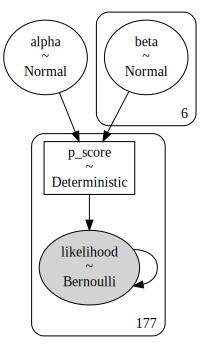

In [ ]:
# --- What does our model look like?
pm.model_to_graphviz(SFM)

<br>

================================================ <font color='green'>**TASK 2 -- START**</font> ================================================

<br>

Draw from the posterior distribution:
- number of samples: &emsp; &emsp; &emsp; &emsp; 10.000
- number of burn-in steps: &ensp; 3.000

In [ ]:
# ========================================== Click the Inference Button ================================================= #

with SFM:

  trace = pm.sample(10000, return_inferencedata=True, tune=3000)


================================================ <font color='green'>**TASK 2 -- End**</font>  =================================================

<br>

**Some Diagnostics of our Sampling**

Even though the sampling may not have triggered any warnings, let's have a closer look by inspecting the trace itself.
When running the following cell, the picture on the right-hand-side should look something like the following:

<br>

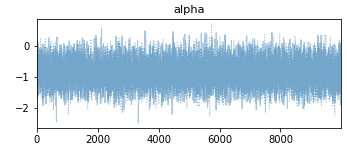



<br>

================================================ <font color='green'>**TASK 3 -- START**</font> ================================================

<br>

Plot the trace of the Markov chain.

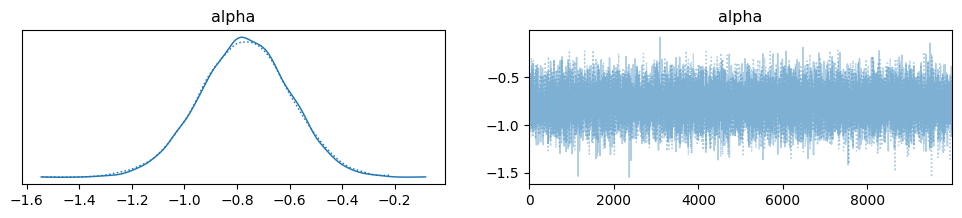

In [ ]:
# ========================================== Diagnostics ================================================= #

with SFM:

  traceplot = az.plot_trace(trace, var_names=["alpha"], compact=True)


================================================ <font color='green'>**TASK 3 -- END**</font> =================================================

<br>

Let's inspect the posterior distribiution of our main parameter of interest -- the (estimated) skill/ability ( $\hat{\alpha}_i$ ) of our player of interest -- a bit more closely:


Of course, the loadings on the team statistics ( $\hat{\beta}$ ) might not be any less interesting!

<br>

================================================ <font color='green'>**TASK 4 -- START**</font> ================================================

<br>

Plot the posterior distribution for $\alpha_i$.

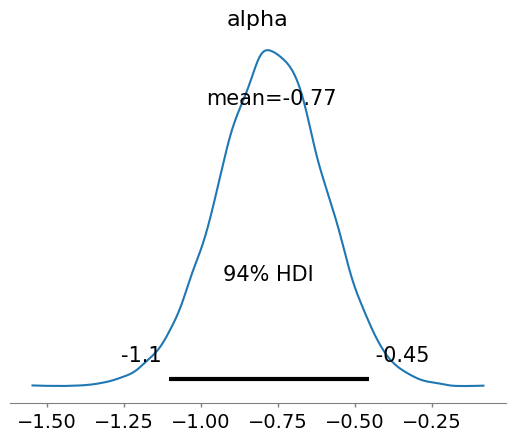

In [ ]:
# ========================================== Diagnostics: Plot Posterior ================================================= #

with SFM:

  az.plot_posterior(trace, var_names=["alpha"])

================================================ <font color='green'>**TASK 4 -- END**</font> =================================================

<br>


So far so good. But now let's do what we are here for and answer our main research question:

<br>


<center><font color='gold' size=4.5>" What is the probability of a player scoring, based only on his Skill/Ability? "</font></center>

<br>

Said differently, what is a player's probability of scoring if all teams were equally strong (or weak)?

<br>

Here we'll go on a liitle detour. Note that instead of using the $\mathtt{sigmoid}$ function, we can rewrite Equation $\left( 1 \right)$ in form of the log-odds-ratio:

<br>

\begin{align}
     log\left(\frac{\hat{p}_{i}}{1-\hat{p}_{i}}\right) = \hat{\alpha}_i + \mathbf{X}_{i} \, \mathbf{\hat{\beta}}
\end{align}

where the little hat above our parameters $\left( \hat{} \right)$ just indicates that these are *estimates* of the *true parameters* that we draw from the joint-posterior distribution (`trace.posterior`).

<br>

We now conduct the following steps to answer our research-question stated above:

> 1. By assuming that *all teams are equally strong*, we set all our "factors" ($\mathbf{X}_{i}$) to 0, such that our model reduces to:

$$log\left(\frac{\hat{p}_{i}}{1-\hat{p}_{i}}\right) = \hat{\alpha}_{i}$$

> 2. Then, we get the probability $\hat{p}_{i}$ by rearranging:

$$\hat{p}_{i} = \frac{e^{\hat{\alpha}_{i}}}{1+e^{\hat{\alpha}_{i}}}$$


> 3. Which value to choose for $\hat{\alpha}_{i}$? The *mean* or the *median*?
I mostly go with the *median*, but feel free to play around.

================================================ <font color='green'>**TASK 5 -- START**</font> ================================================

<br>

Let's get our estimate for $\hat{\alpha}_i$ :

- calculate the mean
- calculate the median

In [ ]:
# --- Let's choose the mean
alpha_mean = np.mean(trace.posterior["alpha"].values)
print("Mean Skill (\u03B1\u1d62): ", np.round(alpha_mean, 2))

# --- Or the median
alpha_median = np.median(trace.posterior["alpha"].values)
print("Median Skill (\u03B1\u1d62): ", np.round(alpha_median, 2))

Mean Skill (αᵢ):  -0.77
Median Skill (αᵢ):  -0.77


================================================ <font color='green'>**TASK 5 -- END**</font> =================================================


================================================ <font color='green'>**TASK 6 -- START**</font> ================================================

<br>

Take either the *mean* or the *median* of $\hat{\alpha}_i$, and transform it into $\hat{p}_i$ using:

$$\hat{p}_{i} = \frac{e^{\hat{\alpha}_{i}}}{1+e^{\hat{\alpha}_{i}}}$$

In [ ]:
# =================================== Define a Helper-Function =================================== #

def sigmoid_activation(x):

  return np.exp(x)/(1+np.exp(x))


In [ ]:
# ---- Probability of Scoring, conditioning on Skill/Ability only (choose either 'alpha_mean' or 'alpha_median'):
prob = sigmoid_activation(alpha_mean)

print("Probability of Scoring (only based on Skill): ", np.round( prob ,2))

Probability of Scoring (only based on Skill):  0.32


================================================ <font color='green'>**TASK 6 -- END**</font> =================================================

<br>

================================================ <font color='green'>**TASK 7 -- START**</font> ================================================

<br>

**Let's define the Uncertainty around our Point Prediction**

That is, define the boundaries $\left[\hat{p}^{low}_{i},\hat{p}^{up}_{i}\right]$ of the interval, within which our point-estimate $\hat{p}_{i}$ ranges with `cred_region` % of certainty.

In [ ]:
# ---- Let's define the Uncertainity:
cred_region = 0.95

# --- --- Get the "alpha" value at the lower- and upper-bounds
alpha_post_up = np.quantile(trace.posterior["alpha"].values, q=1-(1-cred_region)/2)
alpha_post_low = np.quantile(trace.posterior["alpha"].values, q=(1-cred_region)/2)

# --- --- Convert to Probabilities
prob_up = sigmoid_activation(alpha_post_up)
prob_low = sigmoid_activation(alpha_post_low)

print("Credible Region: ", cred_region * 100,"% \n")
print("Probability of Scoring (only based on Skill) -- Lower Bound: ", np.round( prob_low ,2))
print("Probability of Scoring (only based on Skill) -- Upper Bound: ", np.round( prob_up ,2))

Credible Region:  95.0 % 

Probability of Scoring (only based on Skill) -- Lower Bound:  0.25
Probability of Scoring (only based on Skill) -- Upper Bound:  0.39


================================================ <font color='green'>**TASK 7 -- END**</font> =================================================

<br>

Well ... interesting ...

...<font size="4">**but is our model actually any good, or just producing complete crap?**</font>

That is, let's have a look at what our model tells us about the probability of player $i$ scoring a goal ($\hat{Y}_i$), and how well these *in-sample* predictions match the observed occurrences ($Y_i$).

<br><br>

In order to get $\hat{Y}$, we'll draw samples from the **Posterior Predictive Distribution**.
That is, we compute a Bernoulli distribution based on samples of our posterior estimates for the probability of player $i$ scoring ($\hat{p}_i$), which we extract from `trace.posterior["p_score"]`.
What we get in return is a **binary** vector $\hat{Y}$ made up of $0$ and $1$.

<br><br>

Then we can evaluate how well our model's predictions for a player scoring ($\hat{Y}_i = 1$) or not ($\hat{Y}_i = 0$) match our empricially observed data ($Y_i$). Some of the frequently used *evaluation metrics* to do that are:

> - Mean-Squared Error (MSE): &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; the classical metric for regression-models;
> - Log-Probability Loss (Log-Prob): &emsp;&emsp;&emsp; since we're dealing with a classification exercise;
> - Area Under the Curve (AUC): &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; maybe the most common metric for classification exercises;

<br>

I feel most comfortable to judge the model by looking at the AUC (often also called AUROC (Area Under the Receiver-Operating-Cost Curve)). The AUC tells us pretty neatly, whether our model actually adds some value to predict player $i$'s probability to score in the upcoming match.

> $AUC_i = 0.5$: &ensp;&ensp; we can be pretty confident that our model is no good and we could have just tossed a coin instead.

> $AUC_i = 1$: &ensp;&ensp;&ensp;&emsp; we've pretty much nailed it! Not only does our model accurately predict whether <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; player $i$ scores in the upcoming match or not, but we have also done an awesome job in specifying our model <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; (read: which team-factors to include and which not) !

<br>

<font color='darkred'>**DISCLAIMER**</font>: &emsp; When I say "*accurately predict*", beware that this is en entirely *in-sample* (explanatory) analysis. The model may <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; potentially radically overfit, and then produce complete non-sense in an out-of-sample exercise, i.e. on data it has not yet seen.

<br>

While this is a big concern, making out-of-sample predictions is not what this whole exercise had been intended to produce.
That's why I'll save the testing of the model's out-of-sample performance for the future...


<br><br>

Enough rambling, let's move on to the evaluation...

<br>

================================================ <font color='green'>**TASK 8 -- START**</font> ================================================

<br>

In order to evaluate your model's predictive ability, calculate the following metrics:

- Root-Mean-Squared-Error (RMSE), i.e. in classification exercises also called the *Brier Score*

- Log-Probability-Score (Log-Prob)

- Area Under the (Receiver Operating Cost) Curve (AUC)

In [ ]:
# =================================== Define Some Helper-Functions =================================== #

def func_rmse(y_true,y_hat):

  return (np.sum((y_true-y_hat)**2)/len(y_true))**0.5

def func_logprob(y_true,y_hat):

  return -sum((1-y_true) * np.log(np.maximum(1-y_hat,1e-5)) + y_true * np.log(np.maximum(y_hat,1e-5))) / len(y_hat)

In [ ]:
# =================================== Get predictive samples =================================== #

pred_samples = trace.posterior["p_score"].values

# --- Calculate the Mean
mean = np.mean(pred_samples, axis=(0,1)).flatten()

print("Player: " + my_player_single)
print("\n")
print("RMSE:     " , np.round(func_rmse(y_true=Y_train,y_hat=mean),4))
print("Log-Prob: " , np.round(func_logprob(y_true=Y_train,y_hat=mean),4))
print("AUC:      ", np.round(roc_auc_score(y_true=Y_train,y_score=mean),4))


Player: cristiano ronaldo


RMSE:      0.4398
Log-Prob:  0.573
AUC:       0.7106


================================================ <font color='green'>**TASK 8 -- END**</font> =================================================

<br><br>
Hopefully we got an $AUC$ north of at least  $0.65$ -- or even better  $0.70$ (let's not shoot for the moon and hope to get something like $0.85$). Otherwise we should probably think about adjusting our model in terms of which "factors" to in- and exclude.


<br>

**Final Exercise: Time-Series Plot!**

Let's look at the player's probability of scoring -- based on the full model -- over time. The shaded areas are the matches in which the player has scored a goal.

<ipython-input-77-05829cbce10a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_label)


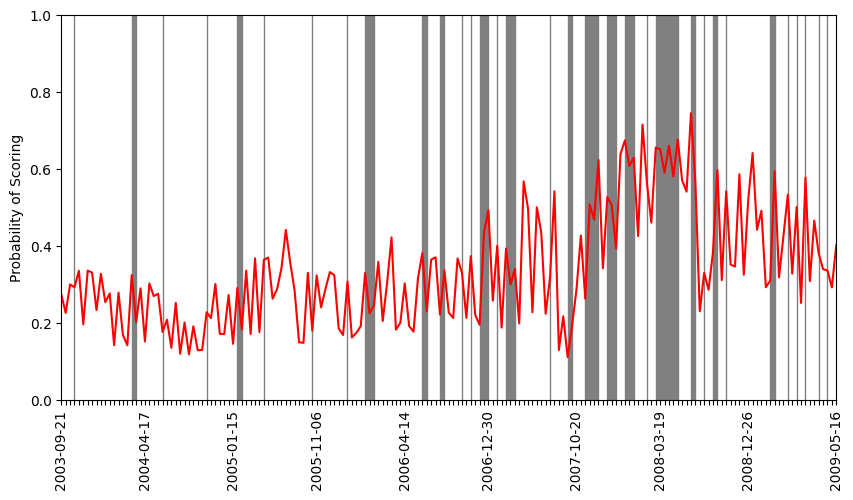

In [ ]:
# ======================== Let's look at the Time-Series of our estimated probabilities (where: P(Y=1|alpha + X' beta)) =================== #

timesteps = data_single.kickoff_dt

# --- Pick 10 labels for the x-axis
x_label = np.repeat('',len(timesteps)).astype('<U10')
for ll in np.linspace(0,len(x_label)-1,10, dtype=int):
  x_label[ll] = timesteps[ll][0:10]


# --- Initialize the plot
fig, ax = plt.subplots(1,1,figsize=(10,5))

# --- Shade the Matches with Goals
ax.fill_between(data_single.kickoff_dt, 0,1,
                    where=data_single['goal'],
                    transform=ax.get_xaxis_transform(),
                    color='gray')

# --- Plot the mean
plt.plot(timesteps,mean,color='red',label='Mean Scoring Probability')


# ---- Some cosmetics
plt.xlim([timesteps[0],timesteps[len(timesteps)-1]])
plt.ylim([0,1])
plt.ylabel('Probability of Scoring')
ax.set_xticklabels(x_label)
ax.tick_params(axis='x',rotation=90)

# ---- Show the plot
plt.show()

<br>
<br>
<br>

### <font size="5" color="red">**2.2 &emsp; Multiple Players**</font>

<br>

*Question*: &emsp;&emsp; Why look at multiple players?

*Answer*: &emsp;&emsp;&emsp;&emsp; We will *pool* the observations of several players, which will give us *more* training-data, <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; which in turn shall improve the precision of our parameter estimates.

<br>

The following cell allows you to specify

> - `my_vars`: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; The list of features $\mathbf{X}$ . You can -- in theory -- choose any variable from `data.columns`.
> - `I_want_stand`: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; The option to standardize the data.

In [ ]:
# ================================== USER INTERACTION ============================== #

# --- Define your explanatory variables [column names of 'data']:
my_vars = ['goalsscored_rank_team','goalsscored_rank_team_wo_player','home_pitch',
           'goalsconceded_rank_opp','points_diff','goal_balance_diff']

# --- Do you want to standardize your data?
I_want_stand = True

# ================================== USER INTERACTION ============================== #

In [ ]:
# ================================== Define your Y and X ============================== #

# --- Get your X and Y
X_train = np.array(data[my_vars]).astype(float)
Y_train = np.array(data['goal'])


# --- Before moving on: do you want to standardize the features?
if I_want_stand == True:

  X_train_true = X_train.copy()

  # --- --- Mean & SD of 'data'
  X_mean = np.mean(X_train_true, axis=0)
  X_sd = np.std(X_train_true, axis=0)

  # ---- --- Standardize 'data'
  X_train = (X_train_true - X_mean) / X_sd

<font size='4'>**How does our model in Equation $\left( 1 \right)$ change?**</font>

<br>

With multiple players in our training set, i.e. with a dataset that is a pooled cross-section of indviduals, we have a few more modeling options available to us.
The intention is of course that these choices will give us more precise estimates of our paramters (i.e. reduce sharpen the posterior distribution of our parameters).

<br>

Given an altered data-structure compared to the <font color="green">single-player</font> model, I will incorporate the following assumptions into the <font color="red">multiple-player</font> model:

> <font color='yellow'>Assumption 1</font>: &emsp; If the goal-scoring probability of player $i$ shows a different sensitivity to the *factors* than player $j$ does, then this <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; should be a sign of *adaptivity* of a given player. This should then not be reflected in $\beta_i$, but in our skill/ability <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; parameter $\alpha_i$. Hence, there won't be any player-specific *factor*-loadings, $\beta_i \;$! <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Our  $\beta$-vector of *factor*-loadings will be *common* across all players!

<br>

> <font color='yellow'>Assumption 2</font>: &emsp; What if our players got better (or worse) over time (i.e. let's allow for "seasonal" skill) ?!

<br>

Thus, we have:

- **individual** skill-/ability-coefficient, that **varies by season**: $\alpha_{i,s}$

- **common** loadings on team-statistics: $\beta$

<br>
<br>

**Model**:


\begin{align}
     p_{i,s} \equiv   P\left(Y_{i,s} = 1 | \mathbf{X}_{i,s}, \alpha_{i,s}, \beta \right) = \sigma \left(\alpha_{i,s} + \mathbf{X}_{i,s} \, \mathbf{\beta} \right) \qquad \left( 2 \right )
\end{align}

<br>

<font color="darkred">**NOTE**</font>: &emsp; Since our skill/ability parameter ($\alpha_{i,s,}$) now carries a subscript $s$, I have also attached it <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&emsp; to our observed outcome variable ($Y_{i,s}$), and our *factors* ($\mathbf{X}_{i,s}$) .

<br>

================================================ <font color='green'>**TASK 1 -- START**</font> ================================================

<br>

Now, using Equation $\left(2\right)$ above, set up the model by thinking about:


- which distributions are appropriate as priors for the parameters $\left(\alpha_{i,s}, \beta\right)$ in our model?
- which distribution best describes the traget variable $\mathbf{Y}_{i,s}$?

<br>

<font color='red'>**NOTE**</font>: Again, the model container below gives you some hints, but don't feel obliged to follow the exact same structure. I will not set any hyperpriors, but feel free to play around and be creative.

In [ ]:
# ========================================== Define the Model ================================================= #

# --- Create a 'player_season' indicator
data['player_season'] = data['name_player'] + [' '] + data['season']

# --- Get your Players' indices --> Now differentiated by Season!
player_idxs, players = pd.factorize(data.player_season)

coords = {"players": players, "obs_id":np.arange(len(player_idxs))}

with pm.Model(coords=coords) as SFM_multi:


  # --- We want to allow for the possibility of player-specific Skill-/Ability-Parameters
  player_idx = pm.ConstantData("player_idx",player_idxs, dims="obs_id")


  # --- Set your priors:

  # --- "\alpha", i.e. the parameter that will give us the Player's ability
  alpha = pm.Normal("alpha",mu=0,sigma=1, dims="players")

  # --- "\beta(s)": the features are designed such that higher/more positive values,
  #     should INCREASE the likelihood of the player scoring ---> i.e. this "decreases" 'alpha'
  #     ---> Option 1:  model "\beta(s)" to be positive numbers
  #     ---> Option 2:  let's be agnostic and allow for negative values as well
  beta = pm.Normal("beta",mu=0,sigma=1,shape=len(my_vars))

  # --- Probability of Scoring:
  p_score = pm.Deterministic('p_score', pm.math.sigmoid(alpha[player_idx] + pm.math.dot(X_train, beta)))

  # --- Fit the Data:
  likelihood = pm.Bernoulli("likelihood", p_score, observed=Y_train, dims="obs_id")


================================================ <font color='green'>**TASK 1 -- END**</font> =================================================

<br>

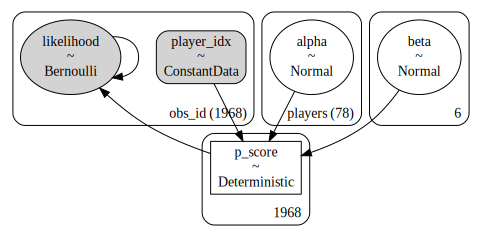

In [ ]:
# --- What does our model look like?
pm.model_to_graphviz(SFM_multi)

<br>

================================================ <font color='green'>**TASK 2 -- START**</font> ================================================

<br>

Draw from the posterior distribution:
- number of samples: &ensp;  &thinsp; &thinsp; &ensp; 10.000
- number of burn-in steps:  &emsp; 10.000

In [ ]:
# ========================================== Click the Inference Button ================================================= #

with SFM_multi:

  trace_multi = pm.sample(10000, return_inferencedata=True, tune=10000)


================================================ <font color='green'>**TASK 2 -- End**</font>  =================================================

<br>

How did our sampling go? Do the traces look reasonable?

<br>

**Some Diagnostics of our Sampling**

The `traceplot` should look similar to the one for a single player. Only that we will now see a trace for each of our $\alpha_{i,s}$.
When running the following cell, the picture on the right-hand-side should therefore look something like the following -- depending on how many players you have previously specified:

<br>

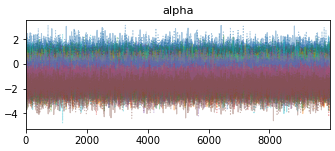



<br>

================================================ <font color='green'>**TASK 3 -- START**</font> ================================================

<br>

Plot the trace of the Markov chains.

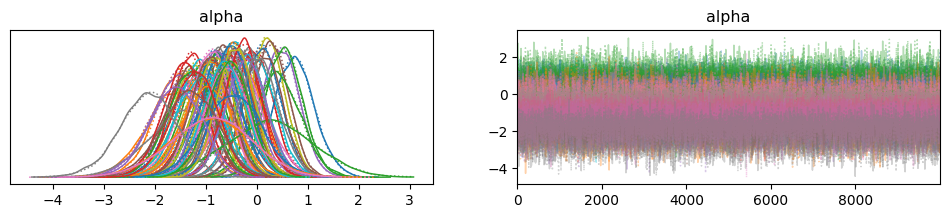

In [ ]:
# ========================================== Diagnostics ================================================= #

with SFM_multi:

  traceplot = az.plot_trace(trace_multi, var_names=["alpha"], compact=True)

================================================ <font color='green'>**TASK 3 -- END**</font> =================================================

<br>

The picture on the left-hand-side already gives us a first impression of our main parameter of interest: the individual skill/ability of player $i$ in season $s$:  $\hat{\alpha}_{i,s}$ .

<br>

Looking at all the densities in a single graph can be quite informative, but someone might want to look at the posterior for each player seperately. [#PyMC](https://www.pymc.io/welcome.html) offers a simple and neat way to do that!

<br>

================================================ <font color='green'>**TASK 4 -- START**</font> ================================================

<br>

Plot the posterior distribution for $\alpha_i$ for each player separately.

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (78) in plot_posterior, generating only 40 plots
  warnings.warn(


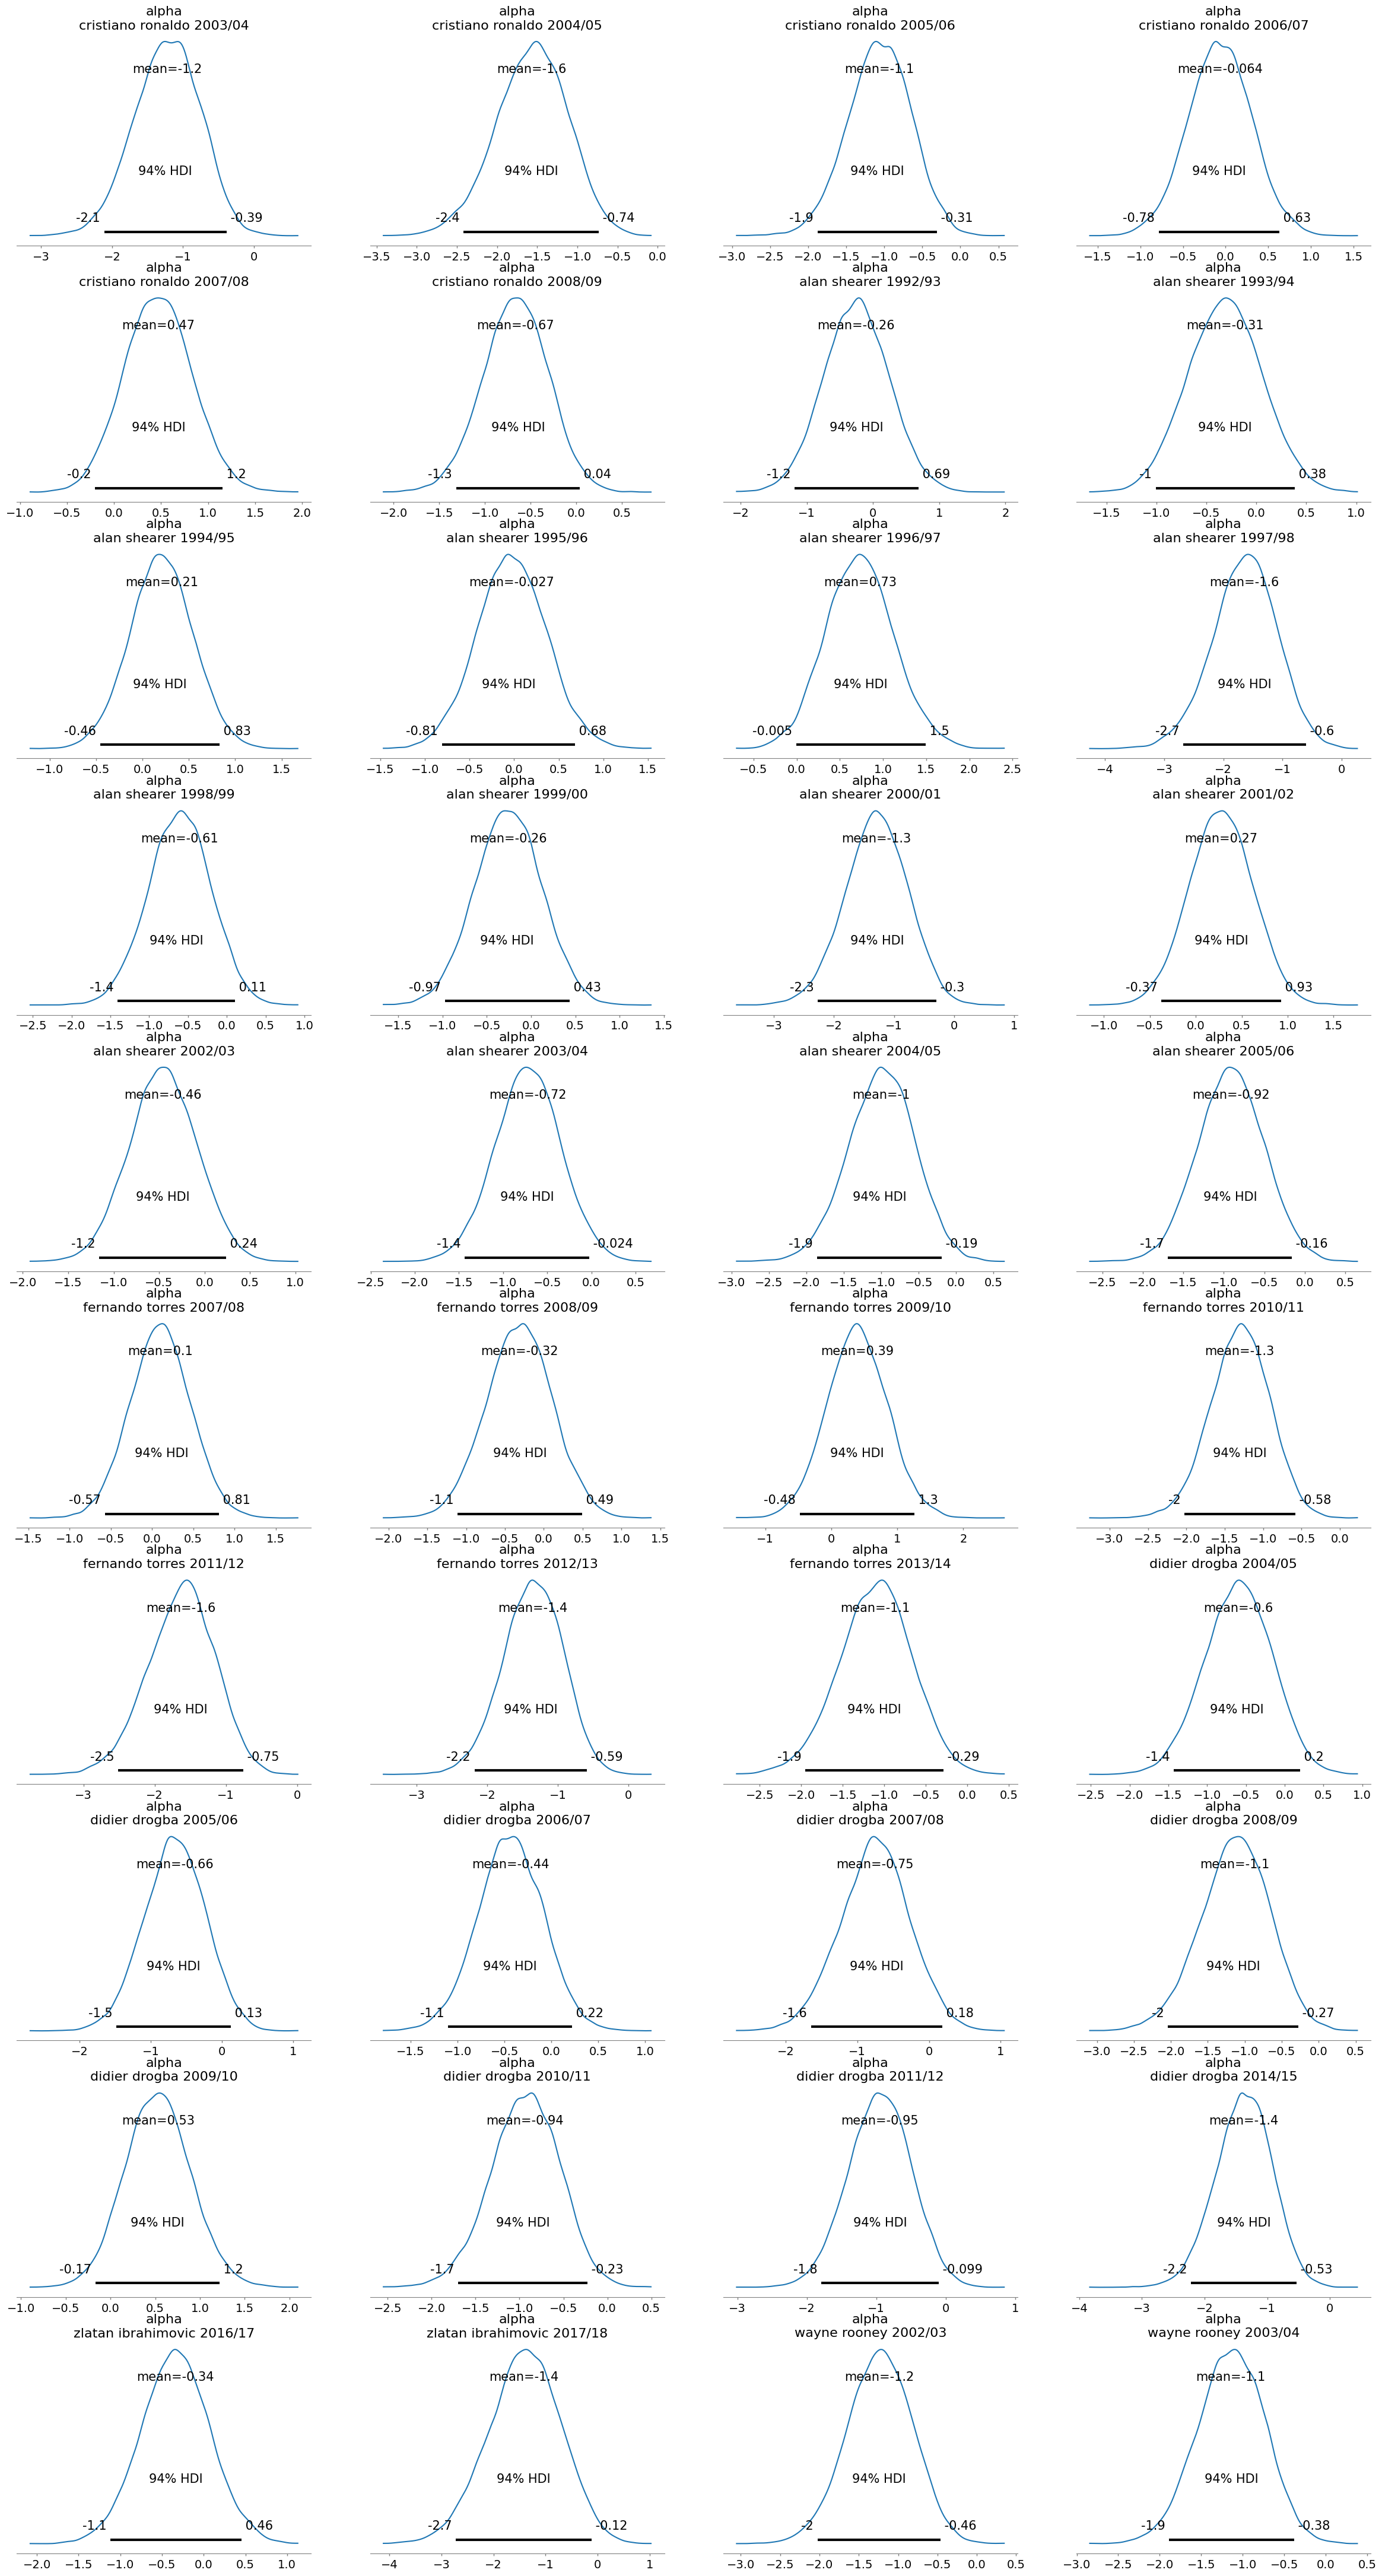

In [ ]:
# ========================================== Diagnostics: Plot Posterior ================================================= #

with SFM_multi:

  az.plot_posterior(trace_multi, var_names=["alpha"])

================================================ <font color='green'>**TASK 4 -- END**</font> =================================================

<br>

Let's use an alterantive visualization technique that allows us to easily compare the posteriors of each of our $\alpha_{i,s}$ in a single chart ! ... Yeah, with many players it looks aweful ... but we already get a really nice overview of how the palyers' skill/ability compares to one another!

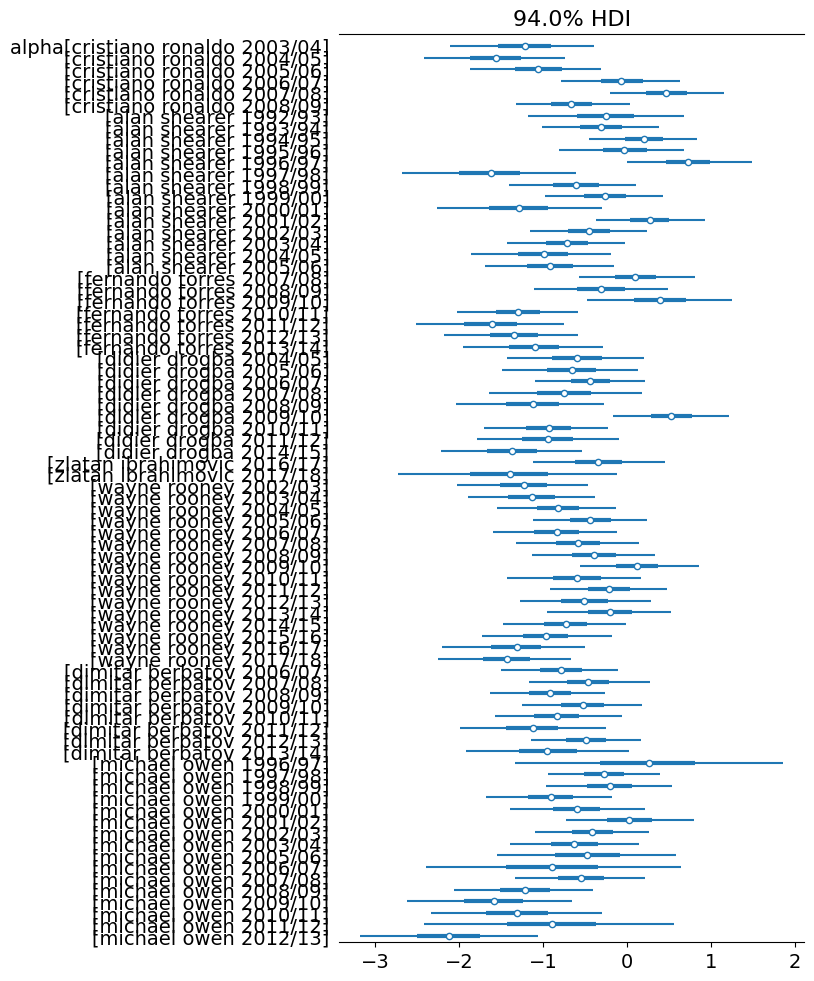

In [ ]:
# ================================== Diagnostics: Plot Posterior -- Alternative Layout ====================================== #

with SFM_multi:

  az.plot_forest(trace_multi, var_names=["alpha"], combined=True)

<br>


Looks all quite pretty -- hopefully ... but now let's do what we are here for and answer our main research question:

<br>


<center><font color='gold' size=4.5>" What is the probability of a player scoring, based only on his Skill/Ability? "</font></center>

<br>

Said differently, what is a player's probability of scoring if all teams were equally strong (or weak)?

<br>

Here we'll go on a little detour. Note that instead of using the $\mathtt{sigmoid}$ function, we can rewrite Equation $\left( 2 \right)$ in form of the log-odds-ratio:

<br>

\begin{align}
     log\left(\frac{\hat{p}_{i,s}}{1-\hat{p}_{i,s}}\right) = \hat{\alpha}_{i,s} + \mathbf{X}_{i,s} \, \mathbf{\hat{\beta}}
\end{align}

where the little hat above our parameters $\left( \hat{} \right)$ means that these are *estimates* that we draw from the joint-posterior distribution (`trace.posterior`).

<br>

As in the case where our object of interest was just a *single* player, we run through the following steps to answer our research-question:

> 1. By assuming that *all teams are equally strong*, we set all our "factors" ($\mathbf{X}_{i,s}$) to 0, such that our model reduces to:

$$log\left(\frac{\hat{p}_{i,s}}{1-\hat{p}_{i,s}}\right) = \hat{\alpha}_{i,s}$$

> 2. Then, we get the probability $\hat{p}_{i,s}$ by rearranging:

$$\hat{p}_{i,s} = \frac{e^{\hat{\alpha}_{i,s}}}{1+e^{\hat{\alpha}_{i,s}}}$$


> 3. Which value to choose for $\hat{\alpha}_{i,s}$? The *mean* or the *median*?
I mostly go with the *median*, but feel free to play around.

================================================ <font color='green'>**TASK 5 -- START**</font> ================================================

<br>

1. For each player $i = 1,...,N$ and each season $s = 1,...,S$, calculate the *mean*, respectively *median*, for the skill/ability parameter ${\hat{\alpha}}_{i,s}$.


2. Transform the skill/ability parameter ${\hat{\alpha}}_{i,s}$ into the corresponding probability $\hat{p}_{i,s}$. <br>
Said differently: calculate the mean/median probability of player $i$ scoring a goal in a given match in season $s$, only based on his skill/ability.

In [ ]:
# ================================== Player Skill/Ability ---> Probability of Scoring ====================================== #
for pp in range(len(players)):

  # ================================== TASK 5 -- Part 1 ================================== #

  # --- Let's choose the mean
  alpha_mean = np.mean(trace_multi.posterior["alpha"][:,:,pp].values)
  print("\nMean Skill ---",players[pp],":   ", np.round(alpha_mean, 2))

  # --- Or the median
  alpha_median = np.median(trace_multi.posterior["alpha"][:,:,pp].values)
  print("Median Skill ---",players[pp],": ", np.round(alpha_median, 2))


  # ================================== TASK 5 -- Part 2 ================================== #

  # ---- Probability of Scoring, conditioning on Skill/Ability only (choose either 'alpha_mean' or 'alpha_median'):
  prob = sigmoid_activation(alpha_median)

  print("Probability of Scoring (only based on Skill) ---",players[pp],": ", np.round( prob ,2))


Mean Skill --- cristiano ronaldo 2003/04 :    -1.23
Median Skill --- cristiano ronaldo 2003/04 :  -1.22
Probability of Scoring (only based on Skill) --- cristiano ronaldo 2003/04 :  0.23

Mean Skill --- cristiano ronaldo 2004/05 :    -1.57
Median Skill --- cristiano ronaldo 2004/05 :  -1.56
Probability of Scoring (only based on Skill) --- cristiano ronaldo 2004/05 :  0.17

Mean Skill --- cristiano ronaldo 2005/06 :    -1.06
Median Skill --- cristiano ronaldo 2005/06 :  -1.06
Probability of Scoring (only based on Skill) --- cristiano ronaldo 2005/06 :  0.26

Mean Skill --- cristiano ronaldo 2006/07 :    -0.06
Median Skill --- cristiano ronaldo 2006/07 :  -0.07
Probability of Scoring (only based on Skill) --- cristiano ronaldo 2006/07 :  0.48

Mean Skill --- cristiano ronaldo 2007/08 :    0.47
Median Skill --- cristiano ronaldo 2007/08 :  0.47
Probability of Scoring (only based on Skill) --- cristiano ronaldo 2007/08 :  0.61

Mean Skill --- cristiano ronaldo 2008/09 :    -0.67
Median Sk

================================================ <font color='green'>**TASK 5 -- END**</font> =================================================


<br>

================================================ <font color='green'>**TASK 6 -- START**</font> ================================================

<br>

**Let's define the Uncertainty around our Point Prediction**

That is, define the boundaries $\left[\hat{p}^{low}_{i,s},\hat{p}^{up}_{i,s}\right]$ of the range, within which our point-estimate $\hat{p}_{i,s}$ ranges with `cred_region` % of certainty.

In [ ]:
# ======================== Player Skill/Ability ---> Probability of Scoring --- Across all Seasons ============================= #


# ---- Let's define the credible region:
cred_region = 0.95


# --- We will also store the probabilities for each player 'by season' and 'across seasons'. This will come in handy quite shortly ...
Player_Skill_season = {key: [] for key in players}
Player_Skill = {key: [] for key in np.unique(data['name_player'])}

print("Credible Region: ", cred_region * 100,"% \n")
for pp in range(len(players)):

  # --- --- Get the "alpha" value at the lower- and upper-bounds
  alpha_post_up = np.quantile(trace_multi.posterior["alpha"][:,:,pp].values, q=1-(1-cred_region)/2)
  alpha_post_median = np.quantile(trace_multi.posterior["alpha"][:,:,pp].values, q=0.5)
  alpha_post_low = np.quantile(trace_multi.posterior["alpha"][:,:,pp].values, q=(1-cred_region)/2)

  # --- --- Convert to Probabilities
  prob_up = sigmoid_activation(alpha_post_up)
  prob_median = sigmoid_activation(alpha_post_median)
  prob_low = sigmoid_activation(alpha_post_low)

  print("Probability of Scoring (only based on Skill) -- Lower Bound ---",players[pp],": ", np.round( prob_low ,2))
  print("Probability of Scoring (only based on Skill) --    Median   ---",players[pp],": ", np.round( prob_median ,2))
  print("Probability of Scoring (only based on Skill) -- Upper Bound ---",players[pp],": ", np.round( prob_up ,2))
  print("\n")

  # --- --- Store the median probabilities by season
  Player_Skill_season[players[pp]] = prob_median

  # --- --- Store the median probabilities across seasons
  pp_name = players[pp][0:(len(players[pp])-8)]
  Player_Skill[pp_name].append(prob_median)


Credible Region:  95.0 % 

Probability of Scoring (only based on Skill) -- Lower Bound --- cristiano ronaldo 2003/04 :  0.1
Probability of Scoring (only based on Skill) --    Median   --- cristiano ronaldo 2003/04 :  0.23
Probability of Scoring (only based on Skill) -- Upper Bound --- cristiano ronaldo 2003/04 :  0.41


Probability of Scoring (only based on Skill) -- Lower Bound --- cristiano ronaldo 2004/05 :  0.08
Probability of Scoring (only based on Skill) --    Median   --- cristiano ronaldo 2004/05 :  0.17
Probability of Scoring (only based on Skill) -- Upper Bound --- cristiano ronaldo 2004/05 :  0.32


Probability of Scoring (only based on Skill) -- Lower Bound --- cristiano ronaldo 2005/06 :  0.13
Probability of Scoring (only based on Skill) --    Median   --- cristiano ronaldo 2005/06 :  0.26
Probability of Scoring (only based on Skill) -- Upper Bound --- cristiano ronaldo 2005/06 :  0.43


Probability of Scoring (only based on Skill) -- Lower Bound --- cristiano ronaldo 2006

================================================ <font color='green'>**TASK 6 -- END**</font> =================================================

<br>



Again a whole load of numbers to digest! They contain a lot of interesting information though:

They tell us for each player $i$ ...
> - ... the *median* probability ( $\bar{p}_{i,s}$ ) of scoring in each match in season $s$ based only on his skill and ability;
> - ... the lower and upper bounds of the range that $p_{i,s}$ falls in, with `cred_region` certainty

<br>

That's cool!
But maybe we can do something even more insightful that helps us understand the effect of player $i$'s team on his probability of scoring!


<br><br>
Therefore, let's have alook at the **excess-skill-metric** $S_{i,s}$. It compares each player's probability of scoring ($\hat{p}_{i,s}$) when accounting for both his ability and his team's strength ($\hat{\alpha}_{i,s} + \mathbf{X}_{i,s} \, \hat{\beta}$) to the probability of him scoring when only accounting for his own skill/ability ($\hat{\alpha}_{i,s}$):

 $$ S_{i,s} = \frac{\frac{e^{\hat{\alpha}_{i,s}}}{1 \; + \; e^{\hat{\alpha}_{i,s}}}}{\frac{e^{\hat{\alpha}_{i,s} + \mathbf{X}_{i,s} \, \hat{\beta}}}{1 \; + \; e^{\hat{\alpha}_{i,s} + \mathbf{X}_{i,s} \, \hat{\beta}}}} \quad ,$$

where $S_{i,s} > 1$ tells us that -- according to the model -- the player's scoring probability was dragged down by his team's performance. Said differently, player $i$'s full potential did not come through while playing for that particular team in season $s$.


<br>

Since we already have stored the estimates for the numerator in `Player_Skill_season`, the only thing that is left to compute $S_{i,s}$ is the denominator.

To estimate the full model ( $\hat{\alpha}_{i,s} + \mathbf{X}_{i,s} \, \hat{\beta}$ ), we could again draw all our parameter-samples from the posterior via `trace_multi.posterior` and simulate some predictions ($\hat{p}_{i,s}$) using our observed factors $\mathbf{X}_{i,s}$. But that sounds like a lot of manual work ...

<br>

... **but with [#PyMC](https://www.pymc.io/welcome.html) it's pretty easy!** The `trace_multi.posterior["p_score"]` array has already got everything what we are looking for, namely the denominator in $S_{i,s}$.

<br>

Awesome! Let's compute our $S_{i,s}$ statistic as described above:

In [ ]:
# ========================================== A Player's EXCESS Skill/Ability ========================================== #

# --- As above, we will store the probabilities for each player 'by season' and 'across seasons'
Player_ProbScore_season = {key: [] for key in players}
Player_ProbScore = {key: [] for key in np.unique(data['name_player'])}


for pp in range(len(my_player)):

  # --- Get the range in the "likelihood-database" that gives you the predictions for player "i" in season "s"
  # --- --- Extract the seasons that the player has played
  season_s = pd.unique(MY_PLAYER[my_player[pp]].season)

  if pp == 0:
    range_prev = 0
  else:
    range_prev = np.sum([MY_PLAYER[my_player[prev]].shape[0] for prev in range(pp)])


  for ss in range(len(season_s)):

    index_ss = MY_PLAYER[my_player[pp]].index[MY_PLAYER[my_player[pp]].season == season_s[ss]]

    # --- Get the range in the "likelihood-database" that gives you the predictions for player "i"
    range_start = range_prev + index_ss[0]
    range_end = range_prev + index_ss[-1]

    #pred_samples = ppc.posterior_predictive.data_vars["likelihood"][:,:,range(range_start,range_end)].values
    pred_samples = trace_multi.posterior["p_score"][:,:,range(range_start,range_end)].values

    # --- Get the Mean
    mean = np.mean(pred_samples).flatten()

    # --- Get the Median --> can be used instead of the mean
    median = np.median(pred_samples).flatten()

    # --- --- Store the median probabilities by season
    pp_name = my_player[pp] + " " + season_s[ss]
    Player_ProbScore_season[pp_name] = mean

    # --- --- Store the median probabilities across seasons
    Player_ProbScore[my_player[pp]].append(mean)

<br>

So let's plot $S_{i,s}$, i.e. player $i$'s *excess-skill* in season $s$!

<br>

> Recall: $\,$ if $S_{i,s} > 1$ -- accordng to the model -- the player is *under-valued* compared to his inherent skill/ability, <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; i.e. the player actually has **excess skill** but his own team is dragging him down.

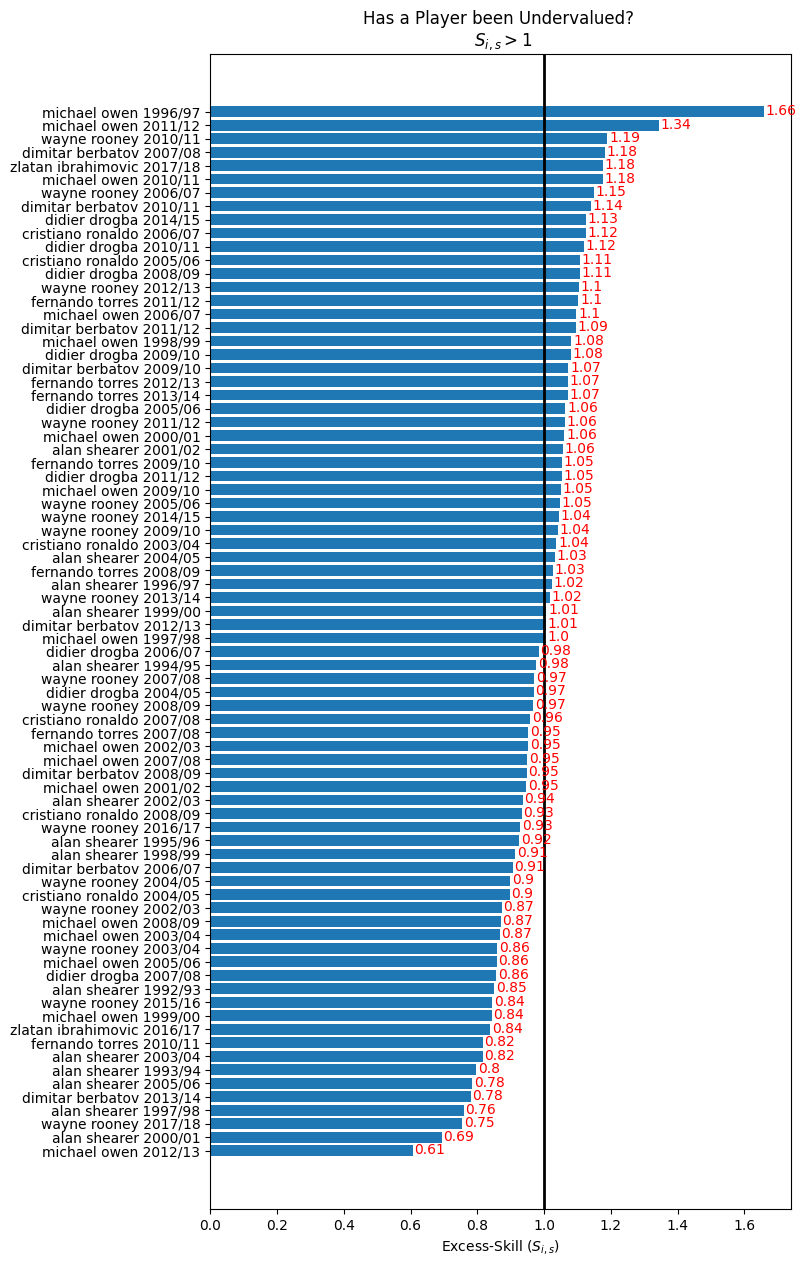

In [ ]:
# --- Initialize the plotting-dataframe
plot_df = pd.DataFrame({"players": Player_ProbScore_season.keys()})

# --- Assemble the ability-/skill-statistics that you have alreday calculated previously
plot_df["S"] = [(Player_Skill_season[pp] / Player_ProbScore_season[pp])[0] for pp in plot_df["players"]]

# --- Sort the dataframe descendingly according to 'S'
plot_df = plot_df.sort_values(by="S", ascending=False, ignore_index=1)

# --- Start plotting!
fig, ax = plt.subplots(1,1,figsize=(7.5,15))
ax.barh(np.arange(plot_df.shape[0]), plot_df["S"].values)
ax.axvline(x=1,color='black',lw=2)
ax.set_yticks(np.arange(plot_df.shape[0]))
ax.set_yticklabels(list(plot_df["players"]))
ax.invert_yaxis()
ax.set_title("Has a Player been Undervalued? \n $S_{i,s} > 1$")
ax.set_xlabel("Excess-Skill ($S_{i,s}$)")

# --- --- Attach the 'S' metric:
for i, _ in enumerate(plot_df['S']):
    ax.text(plot_df.loc[i,'S'] + .005, i + .25, str(np.round(plot_df.loc[i,'S'],2)), color='red')

<br>

Again, with a lot of players in our sample, this figure can get crowded ...

Let's look at a certain subgroup, e.g. the top (bottom) 10.


In [ ]:
# --- To get the Top 10, run this cell
sub_plot_df = plot_df.head(10)

In [ ]:
# --- To get the Bottom 10, run this cell
sub_plot_df = plot_df.tail(10).reset_index(drop=True)

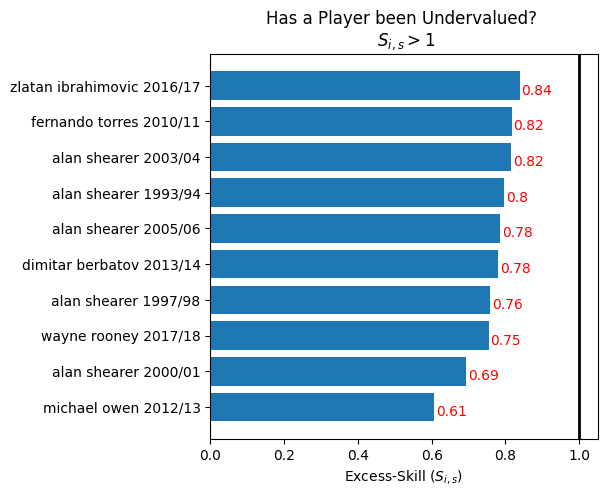

In [ ]:
# --- Plot the subgroup
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.barh(np.arange(sub_plot_df.shape[0]), sub_plot_df["S"].values)
ax.axvline(x=1,color='black',lw=2)
ax.set_yticks(np.arange(sub_plot_df.shape[0]))
ax.set_yticklabels(list(sub_plot_df["players"]))
ax.invert_yaxis()
ax.set_title("Has a Player been Undervalued? \n $S_{i,s} > 1$")
ax.set_xlabel("Excess-Skill ($S_{i,s}$)")

# --- --- Attach the 'S' metric:
for i, _ in enumerate(sub_plot_df['S']):
    ax.text(sub_plot_df.loc[i,'S'] + .005, i + .25, str(np.round(sub_plot_df.loc[i,'S'],2)), color='red')

<br>

But it could also be interesting to look **across seasons**! <br>
Let's just apply a summary metric (naturally the *mean* or *median*) on $S_{i,s}$ (where $S_{i,s}$ itself is either the *mean* or *median* of samples from the posterior distribution) across $s$, and get $S_{i}$, i.e. player $i$'s *excess-skill* across all seasons $s$.

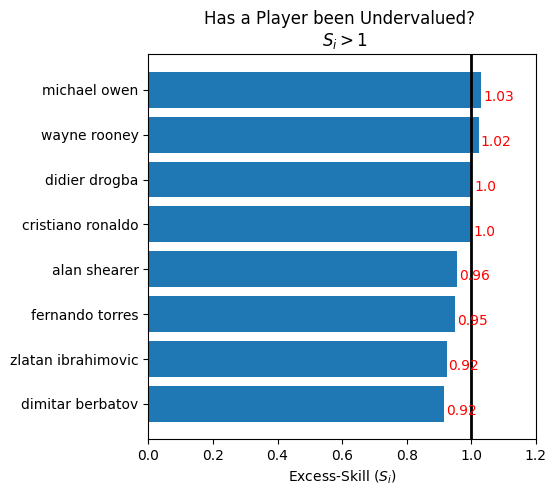

In [ ]:
# --- Set up the data frame for plotting
plot_df = pd.DataFrame({"players": Player_ProbScore.keys()})
# --- Calculate "S": use either 'mean' or 'median'
plot_df["S"] = [np.median(Player_Skill[pp]) / np.median(Player_ProbScore[pp]) for pp in plot_df["players"]]
# --- Sort the dataframe descendingly according to 'S'
plot_df = plot_df.sort_values(by="S", ascending=False, ignore_index=1)


# --- Plot the results
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.barh(np.arange(plot_df.shape[0]), plot_df["S"].values)
ax.axvline(x=1,color='black',lw=2)
ax.set_yticks(np.arange(plot_df.shape[0]))
ax.set_yticklabels(list(plot_df["players"]))
ax.invert_yaxis()
ax.set_xlim(0,1.2)
ax.set_title("Has a Player been Undervalued? \n $S_{i} > 1$")
ax.set_xlabel("Excess-Skill ($S_{i}$)")

# --- --- Attach the 'S' metric:
for i, _ in enumerate(plot_df['S']):
    ax.text(plot_df.loc[i,'S'] + .005, i + .25, str(np.round(plot_df.loc[i,'S'],2)), color='red')

<br>


To recap again: the purpose of $S_{i}$ or $S_{i,s}$ is to evaluate how a  player's probability of scoring only based on his skill/ability, $\; P\left(Y_{i,s} | \hat{\alpha}_i \right) \;$, compares to the probability of him scoring when we also account for his team's strength, $\; P\left(Y_{i,s} | \mathbf{X}_{i,s}\, , \hat{\alpha}_i \, , \hat{\beta} \right) \;$. <br>
Keep in mind that we have built these metrics based on the posterior distribution's *median* (or the *mean*) -- hence, a single point-estimate only. We haven't said anything about the uncertainty around that single number.

But enough for now. Let's go with the academic jargon and say: "Specifying some credible interval around our point-estimate for $S_{i}$ or $S_{i,s}$ is *left for future research*".


<br><br>

On to the last part! As in the single-player example we should ask ourselves ...

... <font size="4">**is our model actually any good, or just producing complete crap?**</font>

That is, let's have a look at what our model tells us about the probability of player $i$ scoring a goal ($\hat{Y}_{i,s}$), and how well these *in-sample* predictions match the observed occurrences ($Y_{i,s}$).

<br><br>

In the following I'll get rid of the subscript $s$ by calculating the metrics for each player $i$ across all seasons $s$, such that $\hat{Y}_{i}$ and $Y_{i}$ are column-vectors of length $L_i = \sum^S_{s=1} M_{i,s} \,$, where $M_{i,s}$ is the total number of matches played by player $i$ in season $s$.

In order to get $\hat{Y}$, we'll draw samples from the **Posterior Predictive Distribution**.
That is, we compute a Bernoulli distribution based on samples of our posterior estimates for the probability of player $i$ scoring ($\hat{p}_i$), which we extract from `trace_multi.posterior["p_score"]`.
What we get in return is a **binary** vector $\hat{Y}$ made up of $0$ and $1$.

<br><br>

Then we can evaluate how well our model's predictions for a player scoring ($\hat{Y}_i = 1$) or not ($\hat{Y}_i = 0$) match our empricially observed data ($Y_i$). Some of the frequently used *evaluation metrics* to do that are:

> - Mean-Squared Error (MSE): &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; the classical metric for regression-models;
> - Log-Probability Loss (Log-Prob): &emsp;&emsp;&emsp; since we're dealing with a classification exercise;
> - Area Under the Curve (AUC): &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; maybe the most common metric for classification exercises;

<br>

I feel most comfortable with judging the model by looking at the AUC (often also called AUROC (Area Under the Receiver-Operating-Cost Curve)). The AUC tells us pretty neatly, whether our model actually adds some value to predict player $i$'s probability to score in the upcoming match.

> $AUC_i = 0.5$: &ensp;&ensp; we can be pretty confident that our model is no good and we could have just tossed a coin instead.

> $AUC_i = 1$: &ensp;&ensp;&ensp;&emsp; we've pretty much nailed it! Not only does our model accurately predict whether <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; player $i$ scores in the upcoming match or not, but we have also done an awesome job in specifying our model <br> &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; (read: which team-factors to include and which not) !

<br>

<font color='darkred'>**DISCLAIMER**</font>: &emsp; Again, when I say "*accurately predict*", beware that this is en entirely *in-sample* (explanatory) analysis. The model may <br> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; potentially radically overfit, and then produce complete non-sense in an out-of-sample exercise, i.e. on data it has not yet seen.

<br>

While *overfitting* is a big concern, making out-of-sample predictions is not what this whole exercise had been intended to produce.
That's why I'll save the testing of the model's out-of-sample performance for the future...


<br><br>

Enough rambling, let's move on to the evaluation...

<br>
<br>

================================================ <font color='green'>**TASK 7 -- START**</font> ================================================

<br>

**Check Evaluation Metrics across all Players**


<br>

As in the Single-Player exercise, let's evaluate our model's performance on the following metrics:

- RMSE -- the square-root of the MSE; in classification exercises also called the *Brier Score*

- Log-Prob

- AUC

<br>

<font color='red'>**NOTE**</font>: Assess the **overall** performance of the model. That is, calculate each metric across **all players** and **all seasons**, i.e. a single number for each metric.

In [ ]:
# =================================== Get predictive samples ACROSS ALL PLAYERS and ALL SEASONS =================================== #

pred_samples = trace_multi.posterior["p_score"].values

# --- Get the mean
mean = np.mean(pred_samples, axis=(0,1)).flatten()

rmse = np.round(func_rmse(y_true=Y_train,y_hat=mean),4)
log_prob = np.round(func_logprob(y_true=Y_train,y_hat=mean),4)
auc = np.round(roc_auc_score(y_true=Y_train,y_score=mean),4)
print("RMSE --- All Players:     ", rmse)
print("Log-Prob --- All Players: ", log_prob)
print("AUC --- All Players:      ", auc)


RMSE --- All Players:      0.4433
Log-Prob --- All Players:  0.5779
AUC --- All Players:       0.7066


================================================ <font color='green'>**TASK 7 -- END**</font> =================================================

<br>


Lastly, let's look at **each player individually, but across all seasons** ...


**Check Evaluation Metrics by Player**

In [ ]:
# ========================= Get predictive samples FOR EACH PLAYER INDVIDUALLY, but ACROSS ALL SEASONS =================================== #

# --- --- Pre-define some variables for counting
range_start = 0

for pp in range(len(my_player)):

  # --- Get the index of the entries for player "i"
  range_end = range_start + MY_PLAYER[my_player[pp]].shape[0]

  # --- Draw the probability of scoring based on the posterior of the model parameters 'alpha' and 'beta'
  pred_samples = trace_multi.posterior["p_score"][:,:,range(range_start,range_end)].values

  # --- Get the Mean
  mean = np.mean(pred_samples, axis=(0,1)).flatten()

  # --- Extract Player pp's 'labels', i.e. observed outcomes:
  Y_train_pp = np.array(MY_PLAYER[my_player[pp]].goal).flatten()


  rmse = np.round(func_rmse(y_true=Y_train_pp,y_hat=mean),4)
  log_prob = np.round(func_logprob(y_true=Y_train_pp,y_hat=mean),4)
  auc = np.round(roc_auc_score(y_true=Y_train_pp,y_score=mean),4)
  print("RMSE ---",my_player[pp],":     ", rmse)
  print("Log-Prob ---",my_player[pp],": ", log_prob)
  print("AUC ---",my_player[pp],":      ", auc)
  print("\n")

  # --- The end of the current player's range is the beginning of the next player's range:
  #     As the German saying goes: "After the game, is before the game!" -- Sepp Herberger (Coach of the first German National Team to win the World Cup (1954))
  range_start = range_end


RMSE --- cristiano ronaldo :      0.4335
Log-Prob --- cristiano ronaldo :  0.56
AUC --- cristiano ronaldo :       0.7381


RMSE --- alan shearer :      0.4609
Log-Prob --- alan shearer :  0.613
AUC --- alan shearer :       0.7174


RMSE --- fernando torres :      0.4064
Log-Prob --- fernando torres :  0.5034
AUC --- fernando torres :       0.7781


RMSE --- didier drogba :      0.4358
Log-Prob --- didier drogba :  0.564
AUC --- didier drogba :       0.7037


RMSE --- zlatan ibrahimovic :      0.4533
Log-Prob --- zlatan ibrahimovic :  0.5875
AUC --- zlatan ibrahimovic :       0.6409


RMSE --- wayne rooney :      0.4516
Log-Prob --- wayne rooney :  0.5974
AUC --- wayne rooney :       0.6372


RMSE --- dimitar berbatov :      0.4469
Log-Prob --- dimitar berbatov :  0.5853
AUC --- dimitar berbatov :       0.6226


RMSE --- michael owen :      0.4383
Log-Prob --- michael owen :  0.5662
AUC --- michael owen :       0.7088




<br><br>

As in the *Single-Player*-case, we hopefully got some $AUC_i$ north of at least  $0.65$ -- or even better  $0.70$ (let's not shoot for the moon and hope to get something like $0.85$). If not, let's think again about our model.

<br><br>

## &emsp; &emsp; <font size="6.5"> **3. &emsp; End of the Game -- On to the Post-Game Ramblings!**</font>

Well, that was interesting! Though this is just an illustrative example, I'd be grateful for any sort of comments, criticism, and suggestions on how to improve the model.


Some *avenues for future research* could be along the lines of:

> - *Hierarchical* model extension, by making use of *hyper-priors*;
> - Create additional *factors*;
> - Build a *multinomial* model, which does not try to predict whether a player scores or not, but the *number of goals* he scores;
> - ...

Hope you enjoyed the journey! Please feel free to reach out at: [https://www.maximiliangoebel.com](https://www.maximiliangoebel.com).